In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5.0)

os.chdir('E:\\Google Drive\\kaggle\\03-facebook\\data')

train = pd.read_csv('train.csv', index_col='row_id')
train.describe()

test = pd.read_csv('test.csv', index_col='row_id')
test['place_id'] = -1
test.head()
test.describe()

,x,y,accuracy,time,place_id
count,8607230.000000,8607230.000000,8607230.000000,8607230.000000,8607230
mean,4.991417,5.006705,92.652076,890463.661617,-1
std,2.866409,2.886888,124.290613,64467.829800,0
min,0.000000,0.000000,1.000000,786242.000000,-1
25%,2.517000,2.502400,42.000000,833220.000000,-1
50%,4.988000,5.000900,64.000000,887462.000000,-1
75%,7.463600,7.505300,79.000000,945491.000000,-1
max,10.000000,10.000000,1026.000000,1006589.000000,-1


The same thing is for the test set, except:
time is in the range of [786242, 1006589] The test and train are time splited.
Let's combind two sets and so some analysis

In [2]:
df = pd.concat([train, test])
idx_test = (df.place_id == -1)
print(df.head())
print(df.tail())
df.describe()

             x       y  accuracy    time    place_id
row_id                                              
0       0.7941  9.0809        54  470702  8523065625
1       5.9567  4.7968        13  186555  1757726713
2       8.3078  7.0407        74  322648  1137537235
3       7.3665  2.5165        65  704587  6567393236
4       4.0961  1.1307        31  472130  7440663949
              x       y  accuracy    time  place_id
row_id                                             
8607225  4.1206  5.2443        58  882527        -1
8607226  5.1170  5.7695        60  984517        -1
8607227  6.6409  8.3626        19  814024        -1
8607228  6.4190  2.9985        68  862916        -1
8607229  8.1017  7.8736         1  845096        -1


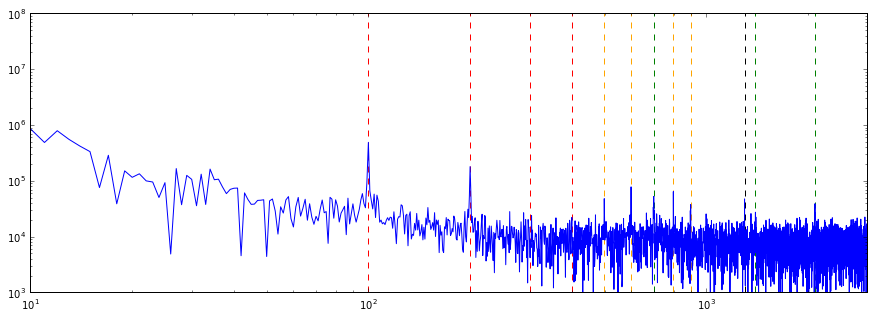

In [16]:
checkins, bins = np.histogram(df.time, bins = range(0, df.time.max()+60, 60))
fft = np.fft.fft(checkins)

plt.xlim(10,3000)
plt.ylim(10**3,10**8)
for x in [100, 200, 300, 400]:
    plt.axvline(x,color='red', ls='--')
for x in [699, 699*2, 699*3]:
    plt.axvline(x,color='green', ls='--')
for x in [499, 599, 799, 899]:
    plt.axvline(x,color='orange', ls='--')
for x in [1298]:
    plt.axvline(x,color='black', ls='--')    
plt.loglog(np.sqrt(fft * fft.conj()).real);
plt.show()

The first peak at the lef (Dashed red line) shows 100 events.  
The other redlines are its harmonics.  
Interestingly, We do not have any harmonic at 300 and 400.  
If we have 100 weeks, then we should have 700 days.  
If we zoom in, we see that there is a peak at 699 and its harmonics at 
1398 and 2097 (green lines).  
Orange lines are modulations of the higher frequency event (days) 
with a lower frequency event (weeks), at 499, 599, 799, 899.

# Simulation
Now lets simulate. We assume a business that is open 8 hours a day, 5 days per week. 
This business has 1 hour of lunch break. 
We produce the data for about 100 weeks (699 days)

In [3]:
rng = pd.date_range('1/1/2013', periods=(100*7-1)*24, freq='H')
checkin_sim = pd.DataFrame(index = rng)
checkin_sim['open'] = 0
checkin_sim['dayofweek'] = rng.dayofweek
checkin_sim['month'] = rng.month
checkin_sim['day'] = rng.day
checkin_sim['hour'] = rng.hour

checkin_sim.ix[(checkin_sim.hour > 8) & (checkin_sim.hour < 17),'open'] = 1
checkin_sim.ix[(checkin_sim.hour == 1),'open'] = 0
checkin_sim.ix[checkin_sim.dayofweek > 4,'open'] = 0
checkin_sim.ix[(checkin_sim.month == 8) & (checkin_sim.month < 15), 'open'] = 0
checkin_sim.ix[(checkin_sim.month == 1) & (checkin_sim.month<7), 'open'] = 0
checkin_sim.ix[(checkin_sim.month == 12) & (checkin_sim.month>24),'open'] = 0

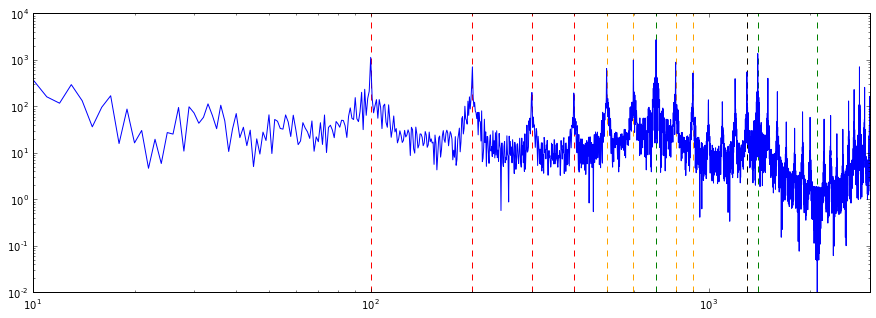

In [17]:
fft = np.fft.fft(checkin_sim.open)

plt.xlim(10, 3000)
plt.ylim(0.01, 10**4)
for x in [100, 200, 300, 400]:
    plt.axvline(x,color='red', ls='--')
for x in [699, 699*2, 699*3]:
    plt.axvline(x,color='green', ls='--')
for x in [499, 599, 799, 899, 1298]:
    plt.axvline(x,color='orange', ls='--')
for x in [1298]:
    plt.axvline(x,color='black', ls='--')    
plt.loglog(np.sqrt(fft * fft.conj()).real);

It is similar, isn't it?  
My conclusion about time: 
1. We have data for 699 days.  
2. The time step is one minute.  

In [5]:
df.time.max()/(699*24*60)

1

Almost there!
Here we discovered the unit of time. 
This remind me of Oil drop experiment, in which Robert Andrews Millikan 
discovered the unit charge of electricity, the charge of an electron.
Let's look at the pattern for 3rd business

In [6]:
pid = train.place_id.value_counts().index[2]
(df[df.place_id == pid].time%(24*60*7)).hist(bins=7*24)
df.min()

x           0
y           0
accuracy    1
time        1
place_id   -1
dtype: float64